## Task statement
Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.

The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification.

The model will help to optimize the production and eliminate unprofitable parameters.

You need to:

* Prepare the data
* Perform data analysis
* Develop and train a model

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from scipy.stats import anderson_ksamp
from sklearn.tree import DecisionTreeRegressor

## Data description
## Technological process

* Rougher feed — raw material
* Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
* Xanthate — promoter or flotation activator;
* Sulphate — sodium sulphide for this particular process;
* Depressant — sodium silicate.
* Rougher process — flotation
* Rougher tails — product residues
* Float banks — flotation unit
* Cleaner process — purification
* Rougher Au — rougher gold concentrate
* Final Au — final gold concentrate

## Parameters of stages

* air amount — volume of air
* fluid levels
* feed size — feed particle size
* feed rate

In [2]:
try:
    full = pd.read_csv('/datasets/gold_recovery_full.csv')

except FileNotFoundError:
    full = pd.read_csv('/datasets/gold_recovery_full.csv')

try:
    test = pd.read_csv('/datasets/gold_recovery_test.csv')

except FileNotFoundError:
    test = pd.read_csv('/datasets/gold_recovery_test.csv')

try:
    train = pd.read_csv('/datasets/gold_recovery_train.csv')

except FileNotFoundError:
    train = pd.read_csv('/datasets/gold_recovery_train.csv')

In [3]:
full['date'] = pd.to_datetime(full['date'])
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                22716 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         22627 non-null  float64       
 2   final.output.concentrate_pb                         22629 non-null  float64       
 3   final.output.concentrate_sol                        22331 non-null  float64       
 4   final.output.concentrate_au                         22630 non-null  float64       
 5   final.output.recovery                               20753 non-null  float64       
 6   final.output.tail_ag                                22633 non-null  float64       
 7   final.output.tail_pb                                22516 non-null  float64       
 8   final.

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


## Check that recovery is calculated correctly 
* Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

In [6]:
train_clean = train.dropna(subset=['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery'])
train_clean = train_clean[['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.recovery']]
train_clean.reset_index(drop=True, inplace=True)
C = train_clean['rougher.output.concentrate_au']
F = train_clean['rougher.input.feed_au']
T = train_clean['rougher.output.tail_au']

pred = ((C * (F - T)) / (F * (C - T))) * 100
actual = train_clean['rougher.output.recovery']
mean_absolute_error(actual, pred)

9.303415616264301e-15

Mean absolute error of 9.303415616264301e-15 is very low value signifying predicted values are extremely close to actual values 

## Test and Train dataframes differ. Neet to find intersection (same columns) between the two. 

In [7]:
train_test_columns = list(set(train.columns).intersection(set(test.columns)))
train_test_columns.sort()
train_test_columns

['date',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air'

## Find rows present in train that are not in test

In [8]:
train_not_test_columns = list(set(train.columns)-set(test.columns))
train_not_test_columns.sort()
train_not_test_columns

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

## What are their types?

In [9]:
train[train_not_test_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_au                         16789 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_au                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


## Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar.

Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets.

In [10]:
#Find perecentage of missing values
train[train_test_columns].isnull().sum()/train.shape[0]

date                                          0.000000
primary_cleaner.input.depressant              0.074852
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.sulfate                 0.077521
primary_cleaner.input.xanthate                0.058422
primary_cleaner.state.floatbank8_a_air        0.002372
primary_cleaner.state.floatbank8_a_level      0.001957
primary_cleaner.state.floatbank8_b_air        0.002372
primary_cleaner.state.floatbank8_b_level      0.001601
primary_cleaner.state.floatbank8_c_air        0.002254
primary_cleaner.state.floatbank8_c_level      0.001601
primary_cleaner.state.floatbank8_d_air        0.002313
primary_cleaner.state.floatbank8_d_level      0.001601
rougher.input.feed_ag                         0.004864
rougher.input.feed_au                         0.004923
rougher.input.feed_pb                         0.013523
rougher.input.feed_rate                       0.030427
rougher.input.feed_size                       0.024733
rougher.in

In [11]:
#Convert date to datetime object and sort by time. This will allow ffill to forward fill if missing value is present. 
train['date'] = pd.to_datetime(train.date)
train.sort_values('date', inplace=True)
train[train_test_columns] = train[train_test_columns].fillna(method='ffill')

In [12]:
train[train_test_columns].isnull().sum()/train.shape[0]

date                                          0.0
primary_cleaner.input.depressant              0.0
primary_cleaner.input.feed_size               0.0
primary_cleaner.input.sulfate                 0.0
primary_cleaner.input.xanthate                0.0
primary_cleaner.state.floatbank8_a_air        0.0
primary_cleaner.state.floatbank8_a_level      0.0
primary_cleaner.state.floatbank8_b_air        0.0
primary_cleaner.state.floatbank8_b_level      0.0
primary_cleaner.state.floatbank8_c_air        0.0
primary_cleaner.state.floatbank8_c_level      0.0
primary_cleaner.state.floatbank8_d_air        0.0
primary_cleaner.state.floatbank8_d_level      0.0
rougher.input.feed_ag                         0.0
rougher.input.feed_au                         0.0
rougher.input.feed_pb                         0.0
rougher.input.feed_rate                       0.0
rougher.input.feed_size                       0.0
rougher.input.feed_sol                        0.0
rougher.input.floatbank10_sulfate             0.0


* Missing values in train[train_test_columns] are taken care of

In [13]:
#Extract targets provided in full but not in the test set 
test['date'] = pd.to_datetime(test.date)
test = test.merge(full[['date', 'final.output.recovery', 'rougher.output.recovery']], how='left', on='date') 

for col in ['final.output.recovery', 'rougher.output.recovery']:
    test[test[col]<0.001] = np.nan

In [14]:
test.sort_values('date', inplace=True)
test.loc[:, train_test_columns] = test.loc[:, train_test_columns].fillna(method='ffill')
test

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,70.273583,89.993421
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,68.910432,88.089657
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,68.143213,88.412756
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,67.776393,87.360133
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,61.467078,83.236367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5735,2017-12-31 23:59:59,181.556856,14.995850,8.070000,1.623454,1498.096303,-499.796922,1501.743791,-505.146931,1499.535978,...,14.914199,-499.948518,10.986607,-500.658027,8.989497,-500.337588,8.988632,-500.764937,NaN,NaN
5736,2017-12-31 23:59:59,181.556856,14.995850,8.070000,1.623454,1498.096303,-499.796922,1501.743791,-505.146931,1499.535978,...,14.914199,-499.948518,10.986607,-500.658027,8.989497,-500.337588,8.988632,-500.764937,NaN,NaN
5737,2017-12-31 23:59:59,181.556856,14.995850,8.070000,1.623454,1498.096303,-499.796922,1501.743791,-505.146931,1499.535978,...,14.914199,-499.948518,10.986607,-500.658027,8.989497,-500.337588,8.988632,-500.764937,NaN,NaN
5738,2017-12-31 23:59:59,181.556856,14.995850,8.070000,1.623454,1498.096303,-499.796922,1501.743791,-505.146931,1499.535978,...,14.914199,-499.948518,10.986607,-500.658027,8.989497,-500.337588,8.988632,-500.764937,NaN,NaN


In [15]:
test.isnull().sum()

date                                            0
primary_cleaner.input.sulfate                   0
primary_cleaner.input.depressant                0
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                  0
primary_cleaner.state.floatbank8_a_air          0
primary_cleaner.state.floatbank8_a_level        0
primary_cleaner.state.floatbank8_b_air          0
primary_cleaner.state.floatbank8_b_level        0
primary_cleaner.state.floatbank8_c_air          0
primary_cleaner.state.floatbank8_c_level        0
primary_cleaner.state.floatbank8_d_air          0
primary_cleaner.state.floatbank8_d_level        0
rougher.input.feed_ag                           0
rougher.input.feed_pb                           0
rougher.input.feed_rate                         0
rougher.input.feed_size                         0
rougher.input.feed_sol                          0
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate               0


In [16]:
#We are still seeing values that are infinite so replace with nan and forward fill
train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.fillna(method='ffill', inplace=True)

test.replace([np.inf, -np.inf], np.nan, inplace=True)
test.fillna(method='ffill', inplace=True)

test.isnull().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [17]:
train.isnull().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

## Analyze the data

* Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

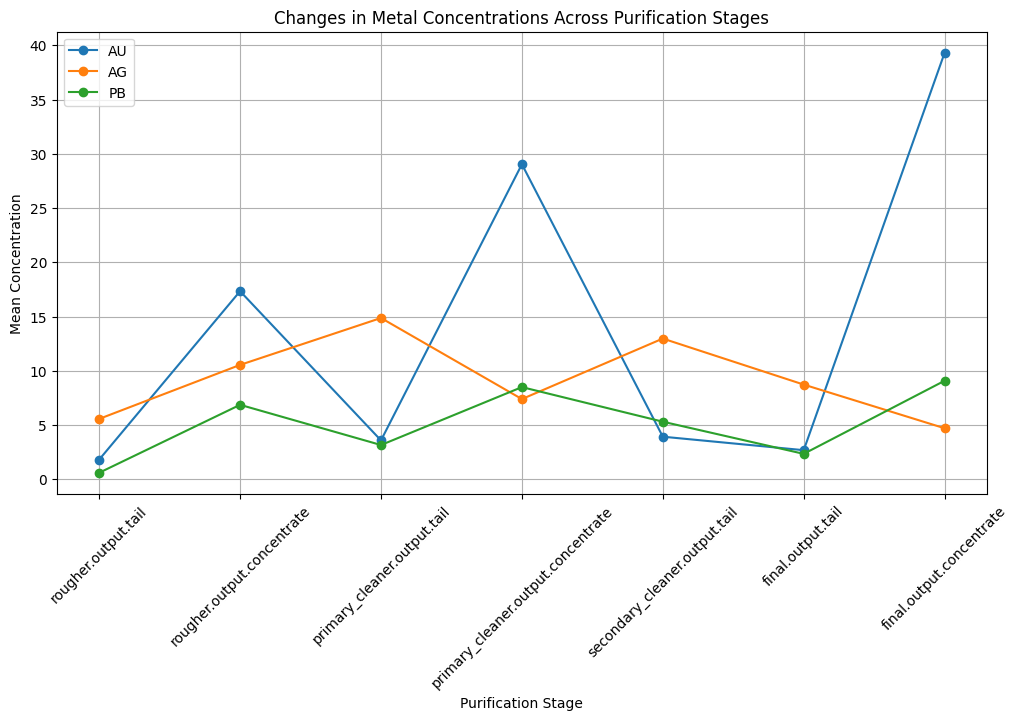

                                           au         ag        pb
rougher.output.tail                  1.808516   5.561737  0.594851
rougher.output.concentrate          17.337662  10.541930  6.861249
primary_cleaner.output.tail          3.580920  14.866588  3.153825
primary_cleaner.output.concentrate  29.041786   7.390585  8.493673
secondary_cleaner.output.tail        3.921555  12.969447  5.303361
final.output.tail                    2.677798   8.725974  2.338107
final.output.concentrate            39.321631   4.699066  9.080638


In [18]:
metals = ['au', 'ag', 'pb']
stages = ['rougher.output.tail', 'rougher.output.concentrate', 'primary_cleaner.output.tail', 'primary_cleaner.output.concentrate', 'secondary_cleaner.output.tail', 'final.output.tail', 'final.output.concentrate'] 

# Initialize a dictionary to store mean concentrations
mean_concentrations = {metal: [] for metal in metals}

# Calculate mean concentrations for each metal at each stage
for metal in metals:
    for stage in stages:
        column_name = f'{stage}_{metal}'
        if column_name in train.columns:
            mean_concentration = train[column_name].mean()
            mean_concentrations[metal].append(mean_concentration)
        else:
            mean_concentrations[metal].append(None)  # If the column does not exist, append None

# Convert to DataFrame for easier plotting
mean_concentrations_df = pd.DataFrame(mean_concentrations, index=stages)

# Plot the changes in concentration
plt.figure(figsize=(12, 6))

# Plot for each metal
for metal in metals:
    plt.plot(mean_concentrations_df.index, mean_concentrations_df[metal], marker='o', label=metal.upper())

plt.title('Changes in Metal Concentrations Across Purification Stages')
plt.xlabel('Purification Stage')
plt.ylabel('Mean Concentration')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Display the mean concentrations for each stage
print(mean_concentrations_df)

* After flotation, we see levels of gold increasing
* Roucher output concentrate begins the purification process and increases a substantial amount after the first stage of cleaner process indicated in the primary_cleaner.output.concentrate. 
* Au then enters its second stage of cleaner process and displays the effectiveness of its cleaning process through its value in the final.output.concentrate.

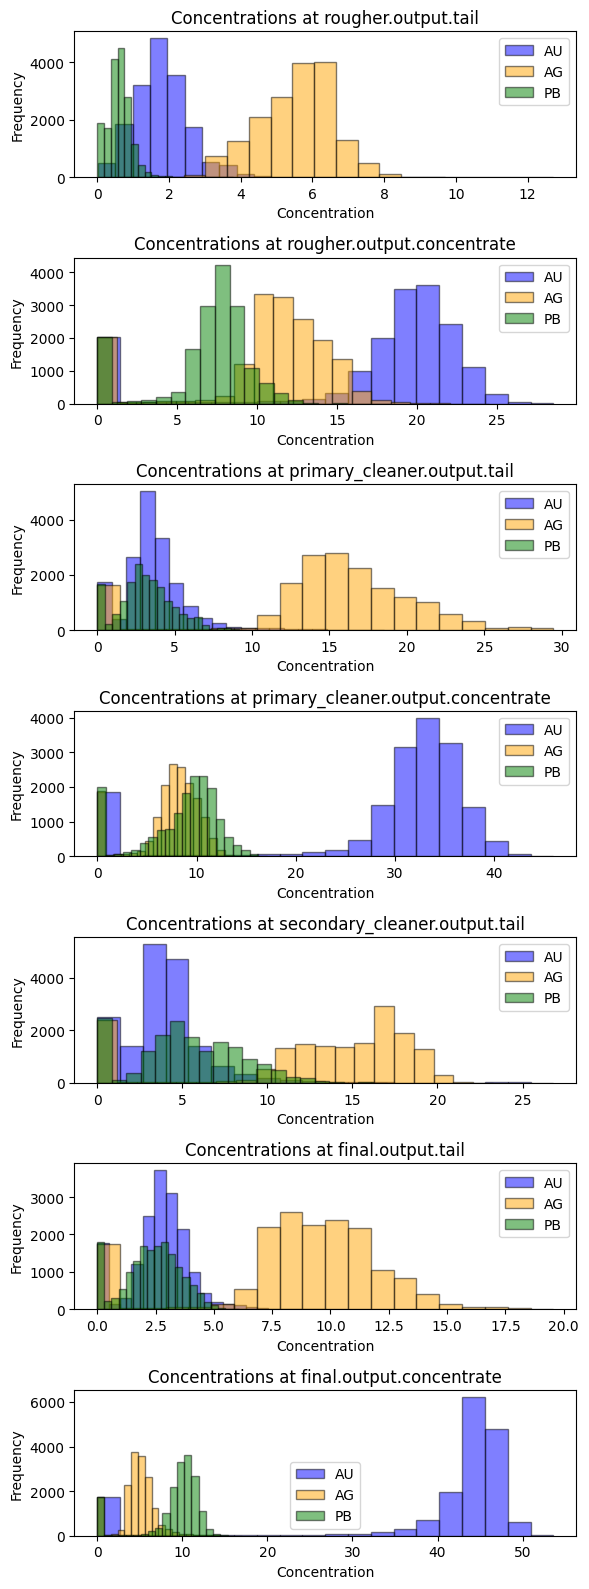

In [19]:
plt.figure(figsize=(6, 16))

colors = ['blue', 'orange', 'green']

for i, stage in enumerate(stages):
    plt.subplot(len(stages), 1, i + 1)
    for j, metal in enumerate(metals):
        column_name = f'{stage}_{metal}'
        if column_name in train.columns:
            train[column_name].plot(kind='hist', bins=20, alpha=0.5, color=colors[j], label=metal.upper(), edgecolor='black')
    
    plt.title(f'Concentrations at {stage}')
    plt.xlabel('Concentration')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

* In many stages, outliers are present for all three metals

## Compare the feed particle size distributions in training & test
* If the distributions vary significantly, the model evaluation will be incorrect.

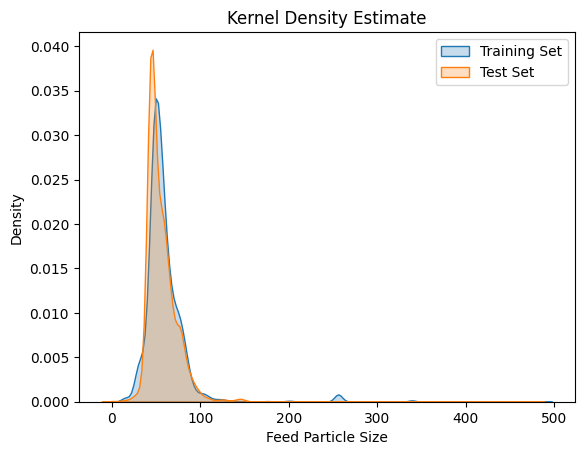

In [20]:
# Sample data for feed particle sizes in training and test sets
# Replace these with your actual data
feed_particle_size_training = train['rougher.input.feed_size']
feed_particle_size_test = test['rougher.input.feed_size']

sns.kdeplot(feed_particle_size_training, label='Training Set', shade=True)
sns.kdeplot(feed_particle_size_test, label='Test Set', shade=True)
plt.xlabel('Feed Particle Size')
plt.ylabel('Density')
plt.title('Kernel Density Estimate')
plt.legend(loc='upper right')
plt.show()

* Distributions do not vary significantly

## Consider the total concentrations of all substances at different stages: 
* raw feed
* rougher concentrate
* final concentrate
* Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies. 

In [21]:
train.shape

(16860, 87)

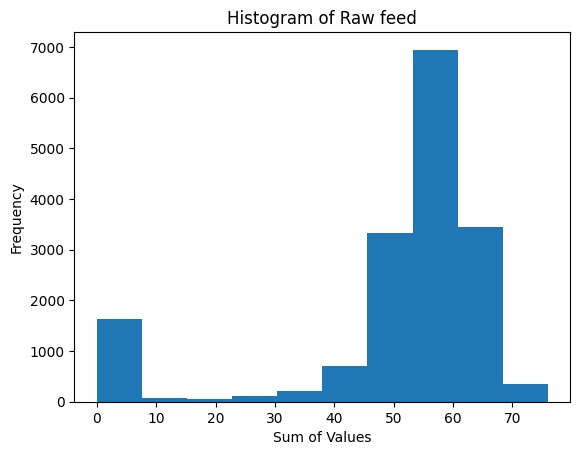

In [22]:
# Correctly sum the columns
rough = ['rougher.input.feed_au', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_ag']
sum_of_columns = np.sum(train[rough].values, axis=1)

plt.hist(sum_of_columns, bins=10)
plt.title('Histogram of Raw feed')
plt.xlabel('Sum of Values')
plt.ylabel('Frequency')
plt.show()

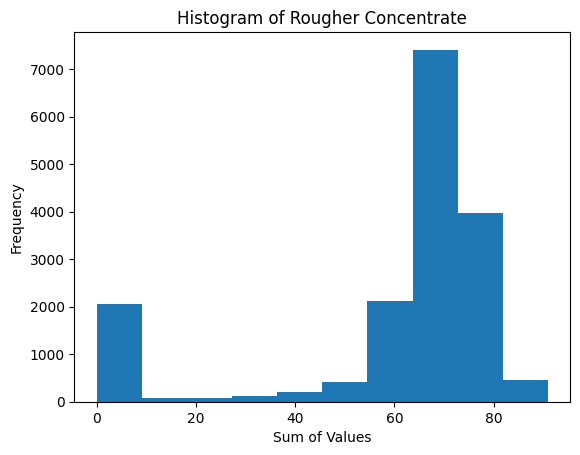

In [23]:
# Correctly sum the columns
out = ['rougher.output.concentrate_au', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_ag']
sum_of_columns = np.sum(train[out].values, axis=1)

plt.hist(sum_of_columns, bins=10)
plt.title('Histogram of Rougher Concentrate')
plt.xlabel('Sum of Values')
plt.ylabel('Frequency')
plt.show()

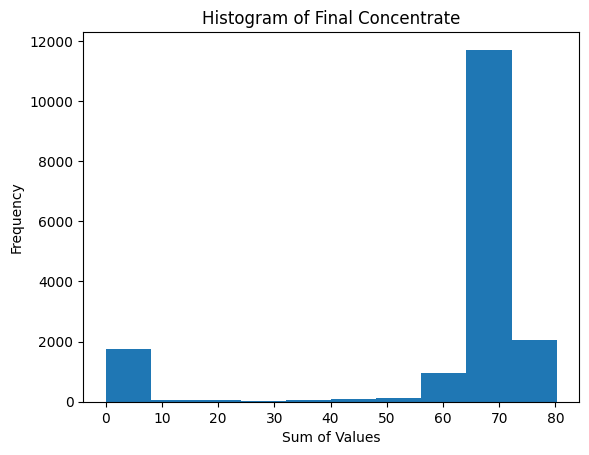

In [24]:
# Correctly sum the columns
final = ['final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_ag']
sum_of_columns = np.sum(train[final].values, axis=1)

plt.hist(sum_of_columns, bins=10)
plt.title('Histogram of Final Concentrate')
plt.xlabel('Sum of Values')
plt.ylabel('Frequency')
plt.show()

* I do not think that the total concentration at any of these stages should be zero
* Need to remove such data from the dataset.

In [25]:
train = train[train[rough].sum(axis=1) > 0]
train = train[train[out].sum(axis=1) > 0]
train = train[train[final].sum(axis=1) > 0]

In [26]:
train.shape

(15128, 87)

In [27]:
target = ['final.output.recovery', 'rougher.output.recovery']
#Skip date
features = train_test_columns[1:] 

In [28]:
X_train, X_test = train[features].values, test[features].values
y_train, y_test = train[target].values, test[target].values

In [29]:
lr = LinearRegression()
st = StandardScaler()
lr.fit(st.fit_transform(X_train), y_train)

LinearRegression()

In [30]:
lr.coef_

array([[-6.12775549e-01,  8.90907444e-01,  3.29837118e+00,
        -6.02431860e-01,  5.82020290e-02,  3.16420719e-02,
         2.82905871e+00, -1.77823797e-01, -3.90966720e+00,
        -5.34571028e-02, -9.92448891e-01, -5.75119704e-01,
        -2.84127942e+00,  6.11258006e+00, -3.15054609e+00,
        -1.16668691e-01, -3.10634386e-01, -1.66130915e+00,
         1.07038669e+00, -1.56842366e+00, -3.07691016e+00,
         3.23891136e+00,  1.84152377e-02, -6.79660360e-01,
         1.06314661e+00, -6.64743862e-01, -2.03668276e+00,
        -1.66869466e-01, -2.40538534e+00,  2.44365714e+00,
        -2.47934670e+00, -2.09516846e+00,  3.83041698e+00,
         1.02671760e+00,  2.46377844e+00, -1.74685190e-01,
        -1.83050127e+00, -1.17823969e+00,  6.12258740e-01,
        -2.42703871e-01, -7.25776913e-01,  4.07990479e-01,
         1.46138615e+00,  1.39737123e-01,  1.79390543e+00,
        -9.65058648e-04,  6.54949809e-01, -5.86768387e-01,
        -1.21250977e+00, -8.39513672e-02, -7.34573900e-0

In [31]:
def smape(y_true, y_pred):
    return(np.abs(y_true - y_pred)/((np.abs(y_true) + np.abs(y_pred))/2)).mean()

In [32]:
smape(y_test[:,0], lr.predict(st.transform(X_test))[:,0])

0.11129822933423708

.11 tells us on average, the difference between our predicted and actual values is about 11.1% of the average of the absolute values of the predicted and actual values.

In [33]:
smape(y_test[:,1], lr.predict(st.transform(X_test))[:,1])

0.05631987780828094

.056 tells us on average, the difference between our predicted and actual values is about 5.6% of the average of the absolute values of the predicted and actual values.

In [34]:
def smape_final(y_true, y_pred):
    #Two target variables
    smape_out_rougher = smape(y_true[:,1], y_pred[:,1])
    smape_out_final = smape(y_true[:,0], y_pred[:,0])
    return (0.25*smape_out_rougher+0.75*smape_out_final)

## CVAL Linear Regression

In [35]:
smape_score = make_scorer(smape_final)

scores_lr = cross_val_score(lr, st.transform(X_train), y_train, cv=5, scoring=smape_score)
print('Mean smape: ', scores_lr.mean())
scores_lr

Mean smape:  0.12111588335267545


array([0.12700893, 0.10336222, 0.09523854, 0.11256935, 0.16740038])

## Decision Tree Regression

In [36]:
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 6): # choose hyperparameter range
    model = DecisionTreeRegressor(random_state=12345, max_depth= depth) # train model on training set
    model.fit(X_train, y_train)
    predictions_valid = model.predict(X_test) # get model predictions on validation set
    result = smape_final(y_test, predictions_valid)
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth  
print(f"smape of the best model on the validation set (max_depth = {best_depth}): {best_result}")

smape of the best model on the validation set (max_depth = 2): 0.10402996961642129


In [37]:
scores_rf = cross_val_score(best_model, st.transform(X_train), y_train, cv=5, scoring=smape_score)
print('Mean smape: ', scores_rf.mean())

Mean smape:  0.10748005644836896


## Random Forest Regression

In [38]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(st.transform(X_train), y_train)
        predictions_valid = model.predict(st.transform(X_test))
        result = smape_final(y_test, predictions_valid)
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("SMAPE of the best model on the validation set:", best_result, "n_estimators:", best_est, "best_depth:", depth)

SMAPE of the best model on the validation set: 0.08858410731292743 n_estimators: 30 best_depth: 10


## CVAL RF Regression

In [39]:
scores_rf = cross_val_score(best_model, st.transform(X_train), y_train, cv=5, scoring=smape_score)
print('Mean smape: ', scores_rf.mean())

Mean smape:  0.10514166973673374


## Final model on test set

In [44]:
predictions = best_model.predict(st.transform(X_test))
smape(y_test, predictions)

0.07763098167989485

## Sanity Check

In [45]:
median_0 = np.median(y_train[:, 0])
median_1 = np.median(y_train[:, 1])

# Create a 2D array
combined_median_predictions = np.array([[median_0, median_1]] * len(y_train))

smape_final(y_train, combined_median_predictions)

0.10817641108010018

In [46]:
median_0 = np.median(y_train[:, 0])
median_1 = np.median(y_train[:, 1])

# Create a 2D array
combined_median_predictions = np.array([[median_0, median_1]] * len(y_test))

smape_final(y_test, combined_median_predictions)

0.09019993713204691

## Conclusion

Using the data on extraction and purification, the random forest model performs best and predicts 
the amount of gold recovered from gold ore. Using hyperparamaters n_estimators: 30 best_depth: 10 
allowed me to narrow it down to 8.8% on the best validation set and 7.7% on the final rf test set. 
Furthermore, a percentage difference of 7.7% is generally low and tells us the model's predictions are close 
to the target. Within the sanity check, I found a 10.8% final smape on the train set and 9% on test which indicates the random forest model performs better.